In [41]:
from pathlib import Path
import typing as t
import pickle

import matplotlib as mpl
SMALLFONTSIZE = 12
MIDFONTSIZE = 16
BIGFONTSIZE = 24
def setupmpl():
    mpl.rcParams['font.size'] = MIDFONTSIZE
    mpl.rcParams['font.family'] = 'serif'
    mpl.rcParams['xtick.labelsize'] = SMALLFONTSIZE
    mpl.rcParams['ytick.labelsize'] = SMALLFONTSIZE
    mpl.rcParams['figure.figsize'] = (10, 6)
    mpl.rcParams['axes.formatter.use_mathtext'] = True
    mpl.rcParams['axes.formatter.useoffset'] = False
    mpl.rcParams['figure.dpi'] = 300
    
# this somehow doesn't get set properly with the dictionary...
plt.rc('figure', figsize=(10, 6))
setupmpl()
setupmpl()
from matplotlib import pyplot as plt

from groundcontrol.jpa_tuner import TuningPoint
from groundcontrol.declarators import quantities
from groundcontrol.measurement import read_measurement_csv
from groundcontrol.analysis.ntfsweep_alt import *
from groundcontrol.analysis.calibrate import remove_baseline
from groundcontrol.analysis.plotting import plot_sppm_mag, plot_tp, plot_sppm_mag, draw_text_box, plot_sasm
from groundcontrol.util import lin2db_pow, db2lin_pow


MARKERS = ['*', '^', 'D', '>', '<', 'x']

# 1. Parameters & Assumptions
We have the following generic model for relevant components in the estimation.

![Noise Temperature Estimation Model](img/ntestmodel.png)

In [39]:
# Assumptions
# Gain of the rest of the chain:  Need not be very precise as it is estimated with data as well.
G_R = db2lin_pow(70)  # dB

# Gain of the losses until the ref plane, no coupler.
G_l = db2lin_pow(-0.05)

# Gain of the tee, actually not relevant for now.
G_t = db2lin_pow(-0.2)

# Rough estimation for circulator loss.
G_c1 = db2lin_pow(-0.2)  # think of Gc1 as coupler
G_c2 = db2lin_pow(-0.4)  # dB

# Fridge temperature
TF = 0.04 # Kelvin

# Noise temperature of the rest of the chain.
# For higher JPA gains, this need not be very precise for the
# correct estimation
Tn_R = 2 # Kelvin

Tn_R_alt = 1.5

OUTDIR = Path('../img/')

DIR = Path("~/Measurements/BF3_JPA/200413/NT_f5.846G_REP2/").expanduser()

# 2. Reading the dataset

In [3]:
# first column is res freq and second is temperature point
bs = SweepBrowser.from_path(DIR, temperature_col=1, frequency_col=0)

freq_sp_ghz = bs.sweepdf.fr.unique()/1e9
print(f"Total NT dataset count: {bs.ndcount}")
print(f"NS Temperatures: {', '.join(map('{:.1f}'.format, bs.sweepdf.tp.unique()*1e3))} mK")
print(f"Frequency Setpoints: {', '.join(map('{:.6f}'.format, freq_sp_ghz))} GHz")
print(f"Frequency Setpoint Indices: {', '.join(map('{:d}'.format, range(len(freq_sp_ghz))))}")

Total NT dataset count: 2
NS Temperatures: 70.0, 105.0, 140.0, 175.0, 210.0 mK
Frequency Setpoints: 2.280000 GHz
Frequency Setpoint Indices: 0


## 2.1 All Baselines

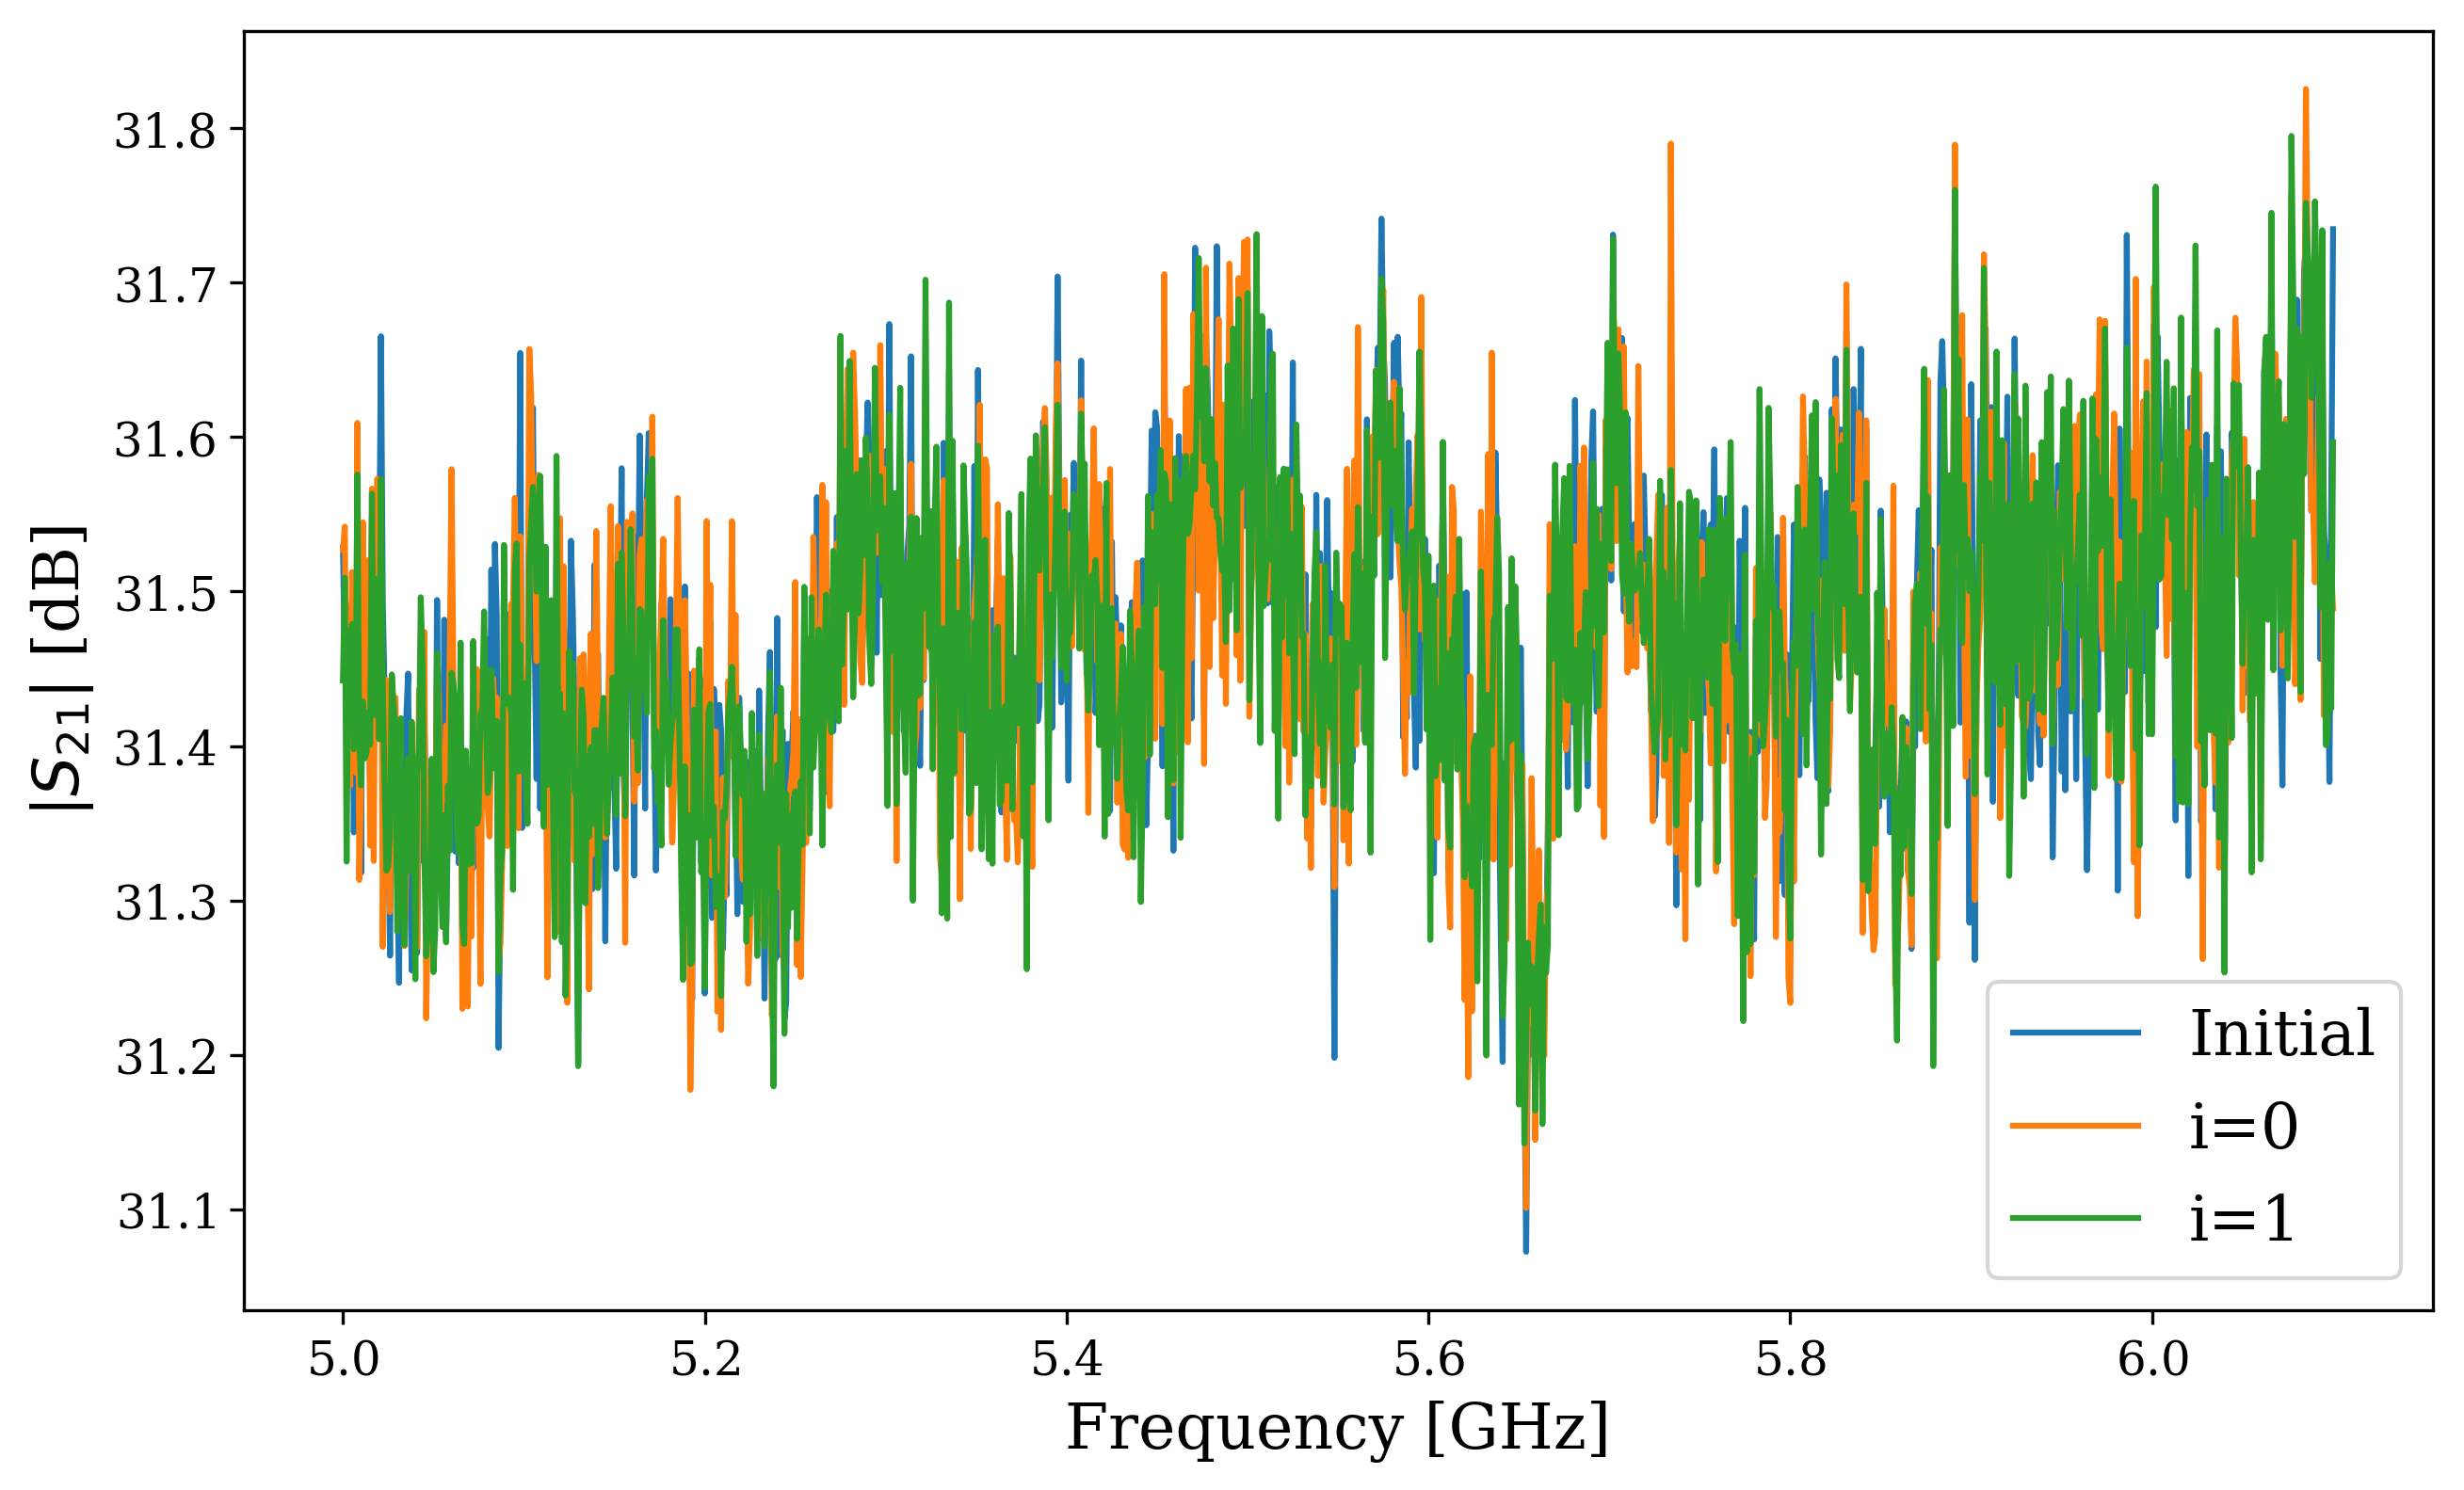

In [43]:
fig, ax = plt.subplots()

bl0 = bs.read_baseline()
plot_sppm_mag(bl0, ax, label=f"Initial")

for i in range(bs.ndcount):
    bl = bs.read_baseline(i)
    plot_sppm_mag(bl, ax, label=f"i={i:d}")

ax.grid()
ax.legend()

## 2.2 Specific Datasets
Simplest way to read is to use the FINDEX, which is a natural number.  It can correspond to repetitions in a repeated measurement, or the different tuning frequencies.

In [5]:
FINDEX = 0
ntds = bs.read_nt_dataset(FINDEX)
ntds.temps

array([0.07 , 0.105, 0.14 , 0.175, 0.21 ])

### 2.2.1 Noise Spectra

PEAK FREQUENCY: 5.846 GHz
GAIN: 23.32 dB


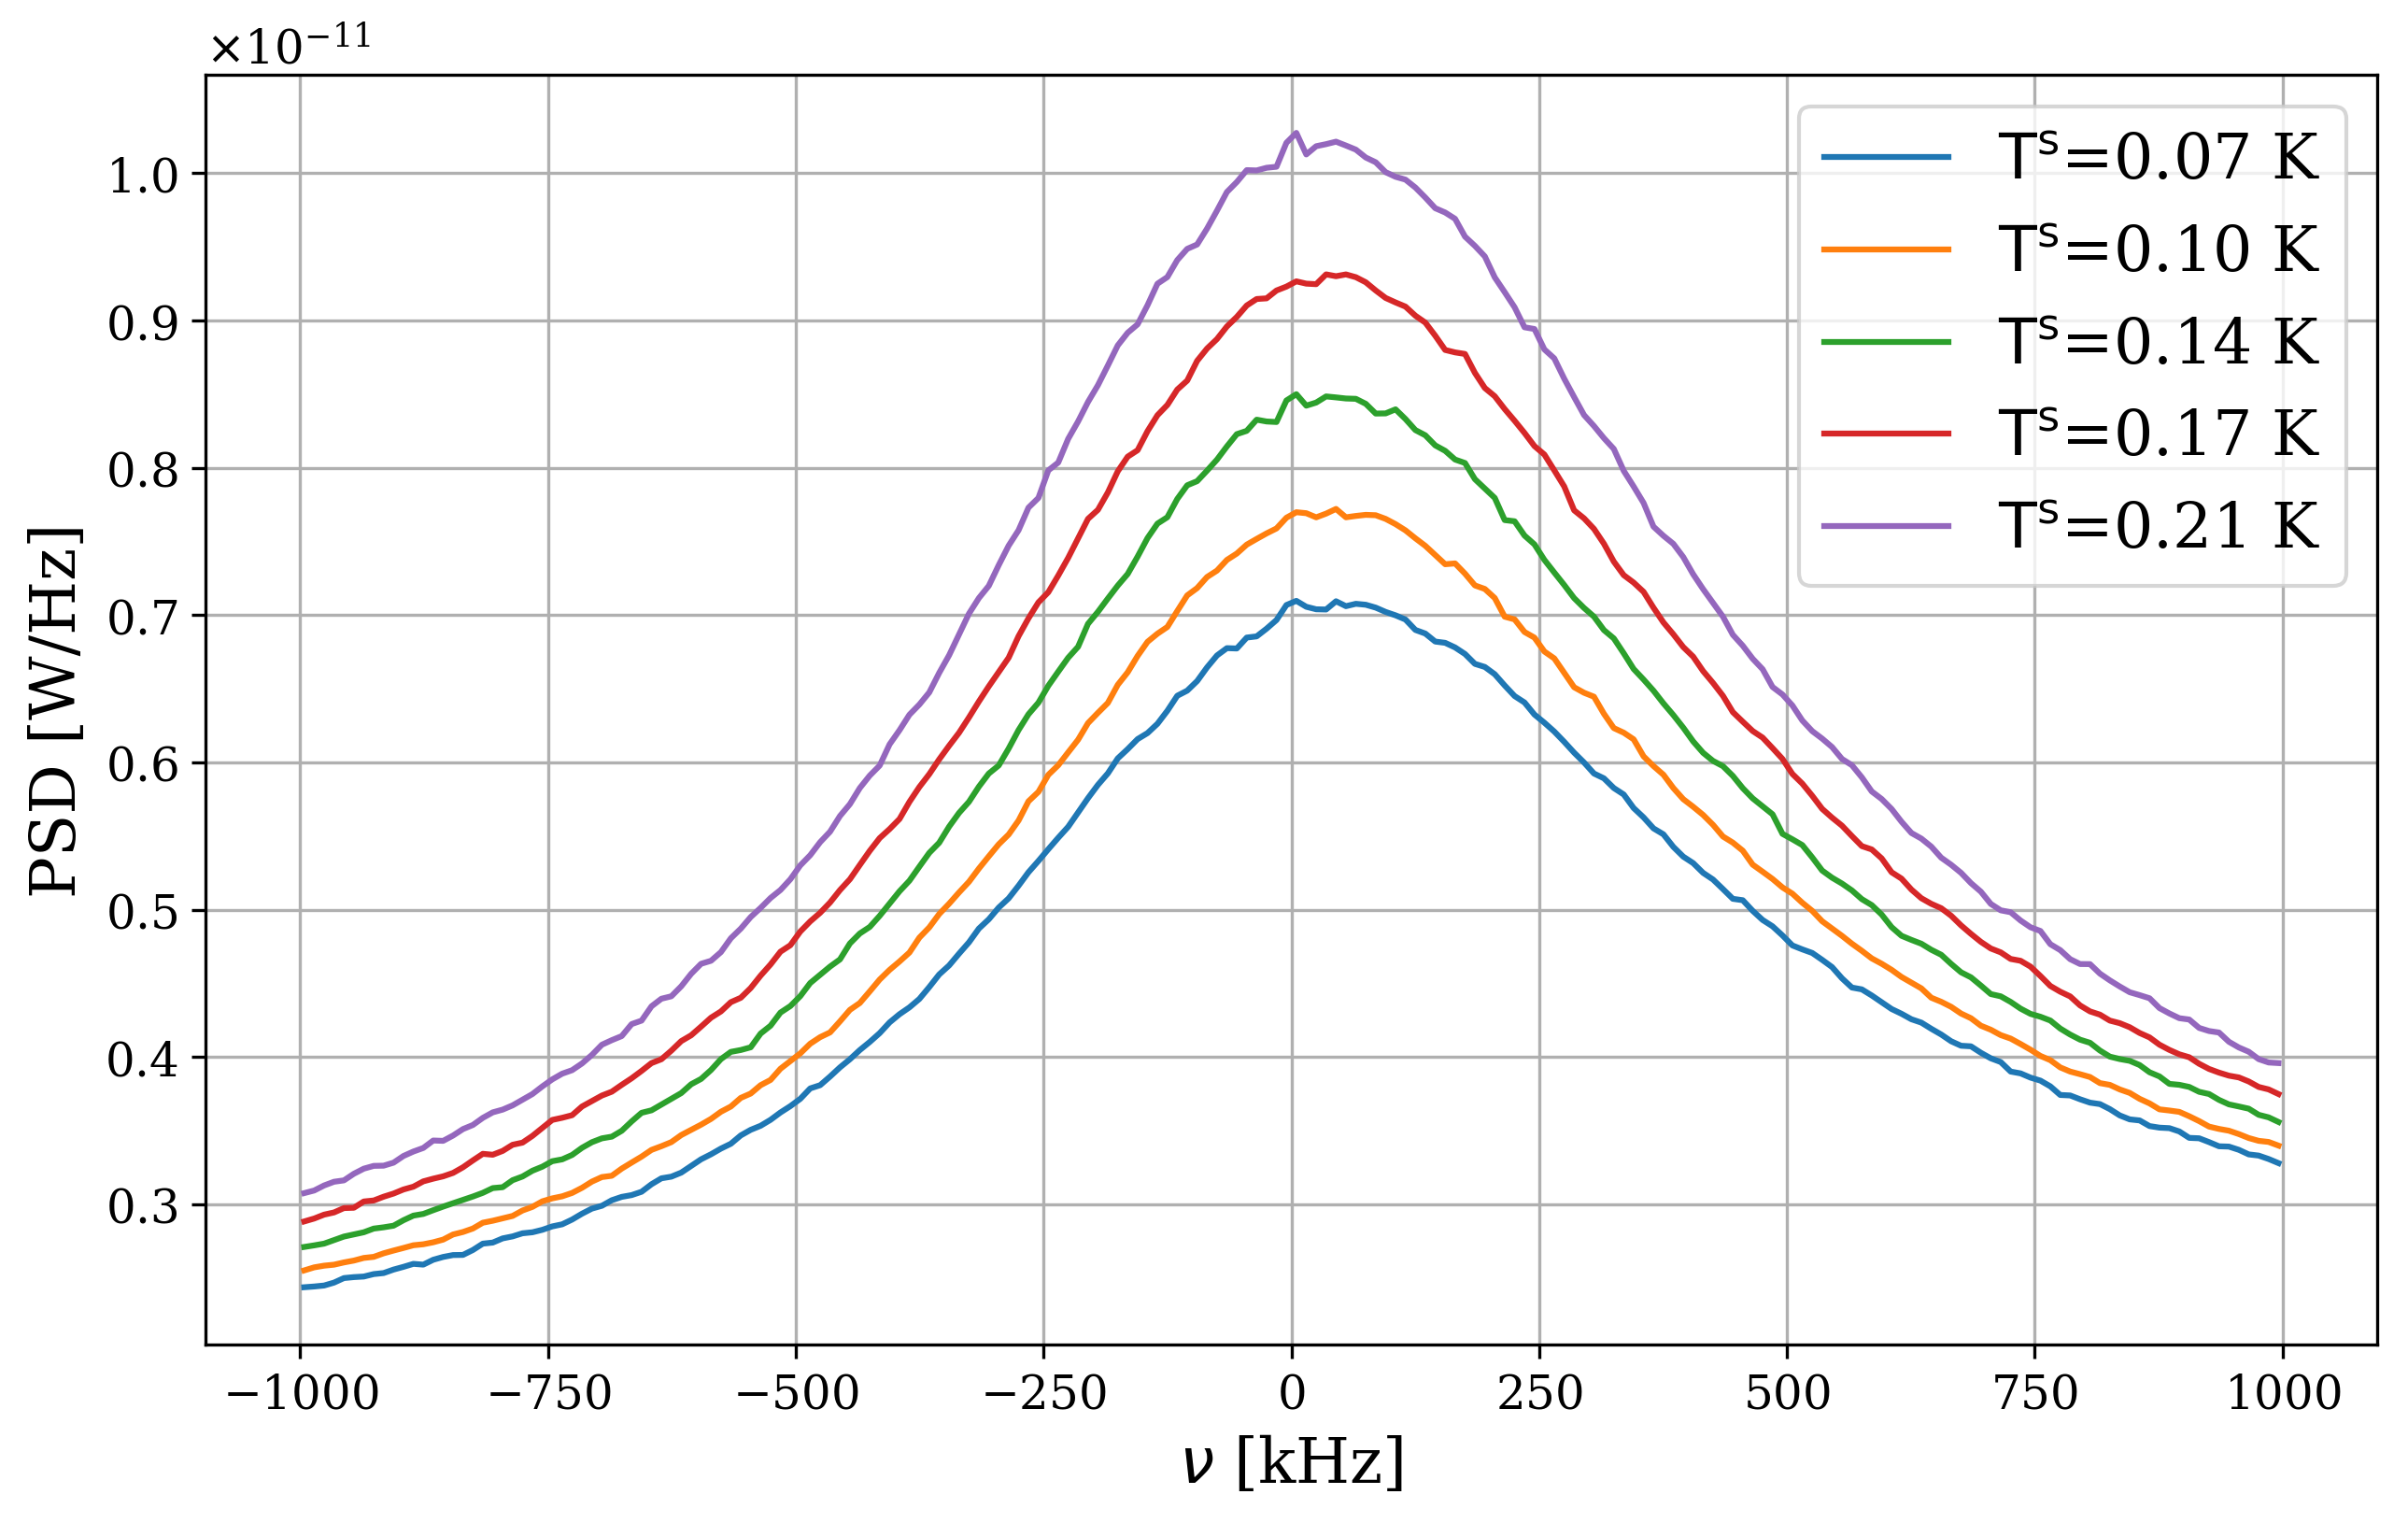

In [54]:
FBAND = 2e6
fmin, fmax = -FBAND/2, +FBAND/2

fpeak = ntds.tup.peak_frequency

fig, ax = plt.subplots()
for t, psd in zip(ntds.temps, ntds.psds):
    qs = quantities(psd)
    f = fpeak - psd.f
    mask = (f >= fmin)*(f <= fmax)
    ax.plot(f[mask]/1e3, psd.s[mask], label=f'$\mathrm{{T}}^{{\mathrm{{s}}}}$={t:.2f} K')
#    ax.set_xlabel(f"{qs['f'].repr} [{qs['f'].unit}]")
#    ax.set_ylabel(f"{qs['s'].repr} [{qs['s'].unit}]")
ax.set_xlabel("$ \\nu $ [kHz]")
ax.set_ylabel("PSD [W/Hz]")
    
ax.legend(fontsize=MIDFONTSIZE)
ax.grid()
#ax.set_title(f"$f_{{peak}}$ = {ntds.tup.peak_frequency/1e9:.3f} GHz | G = {ntds.tup.offset_gain:.2f}");

print(f"PEAK FREQUENCY: {ntds.tup.peak_frequency/1e9:.3f} GHz")
print(f"GAIN: {ntds.tup.offset_gain:.2f} dB")

### 2.2.2 Gain Spectra

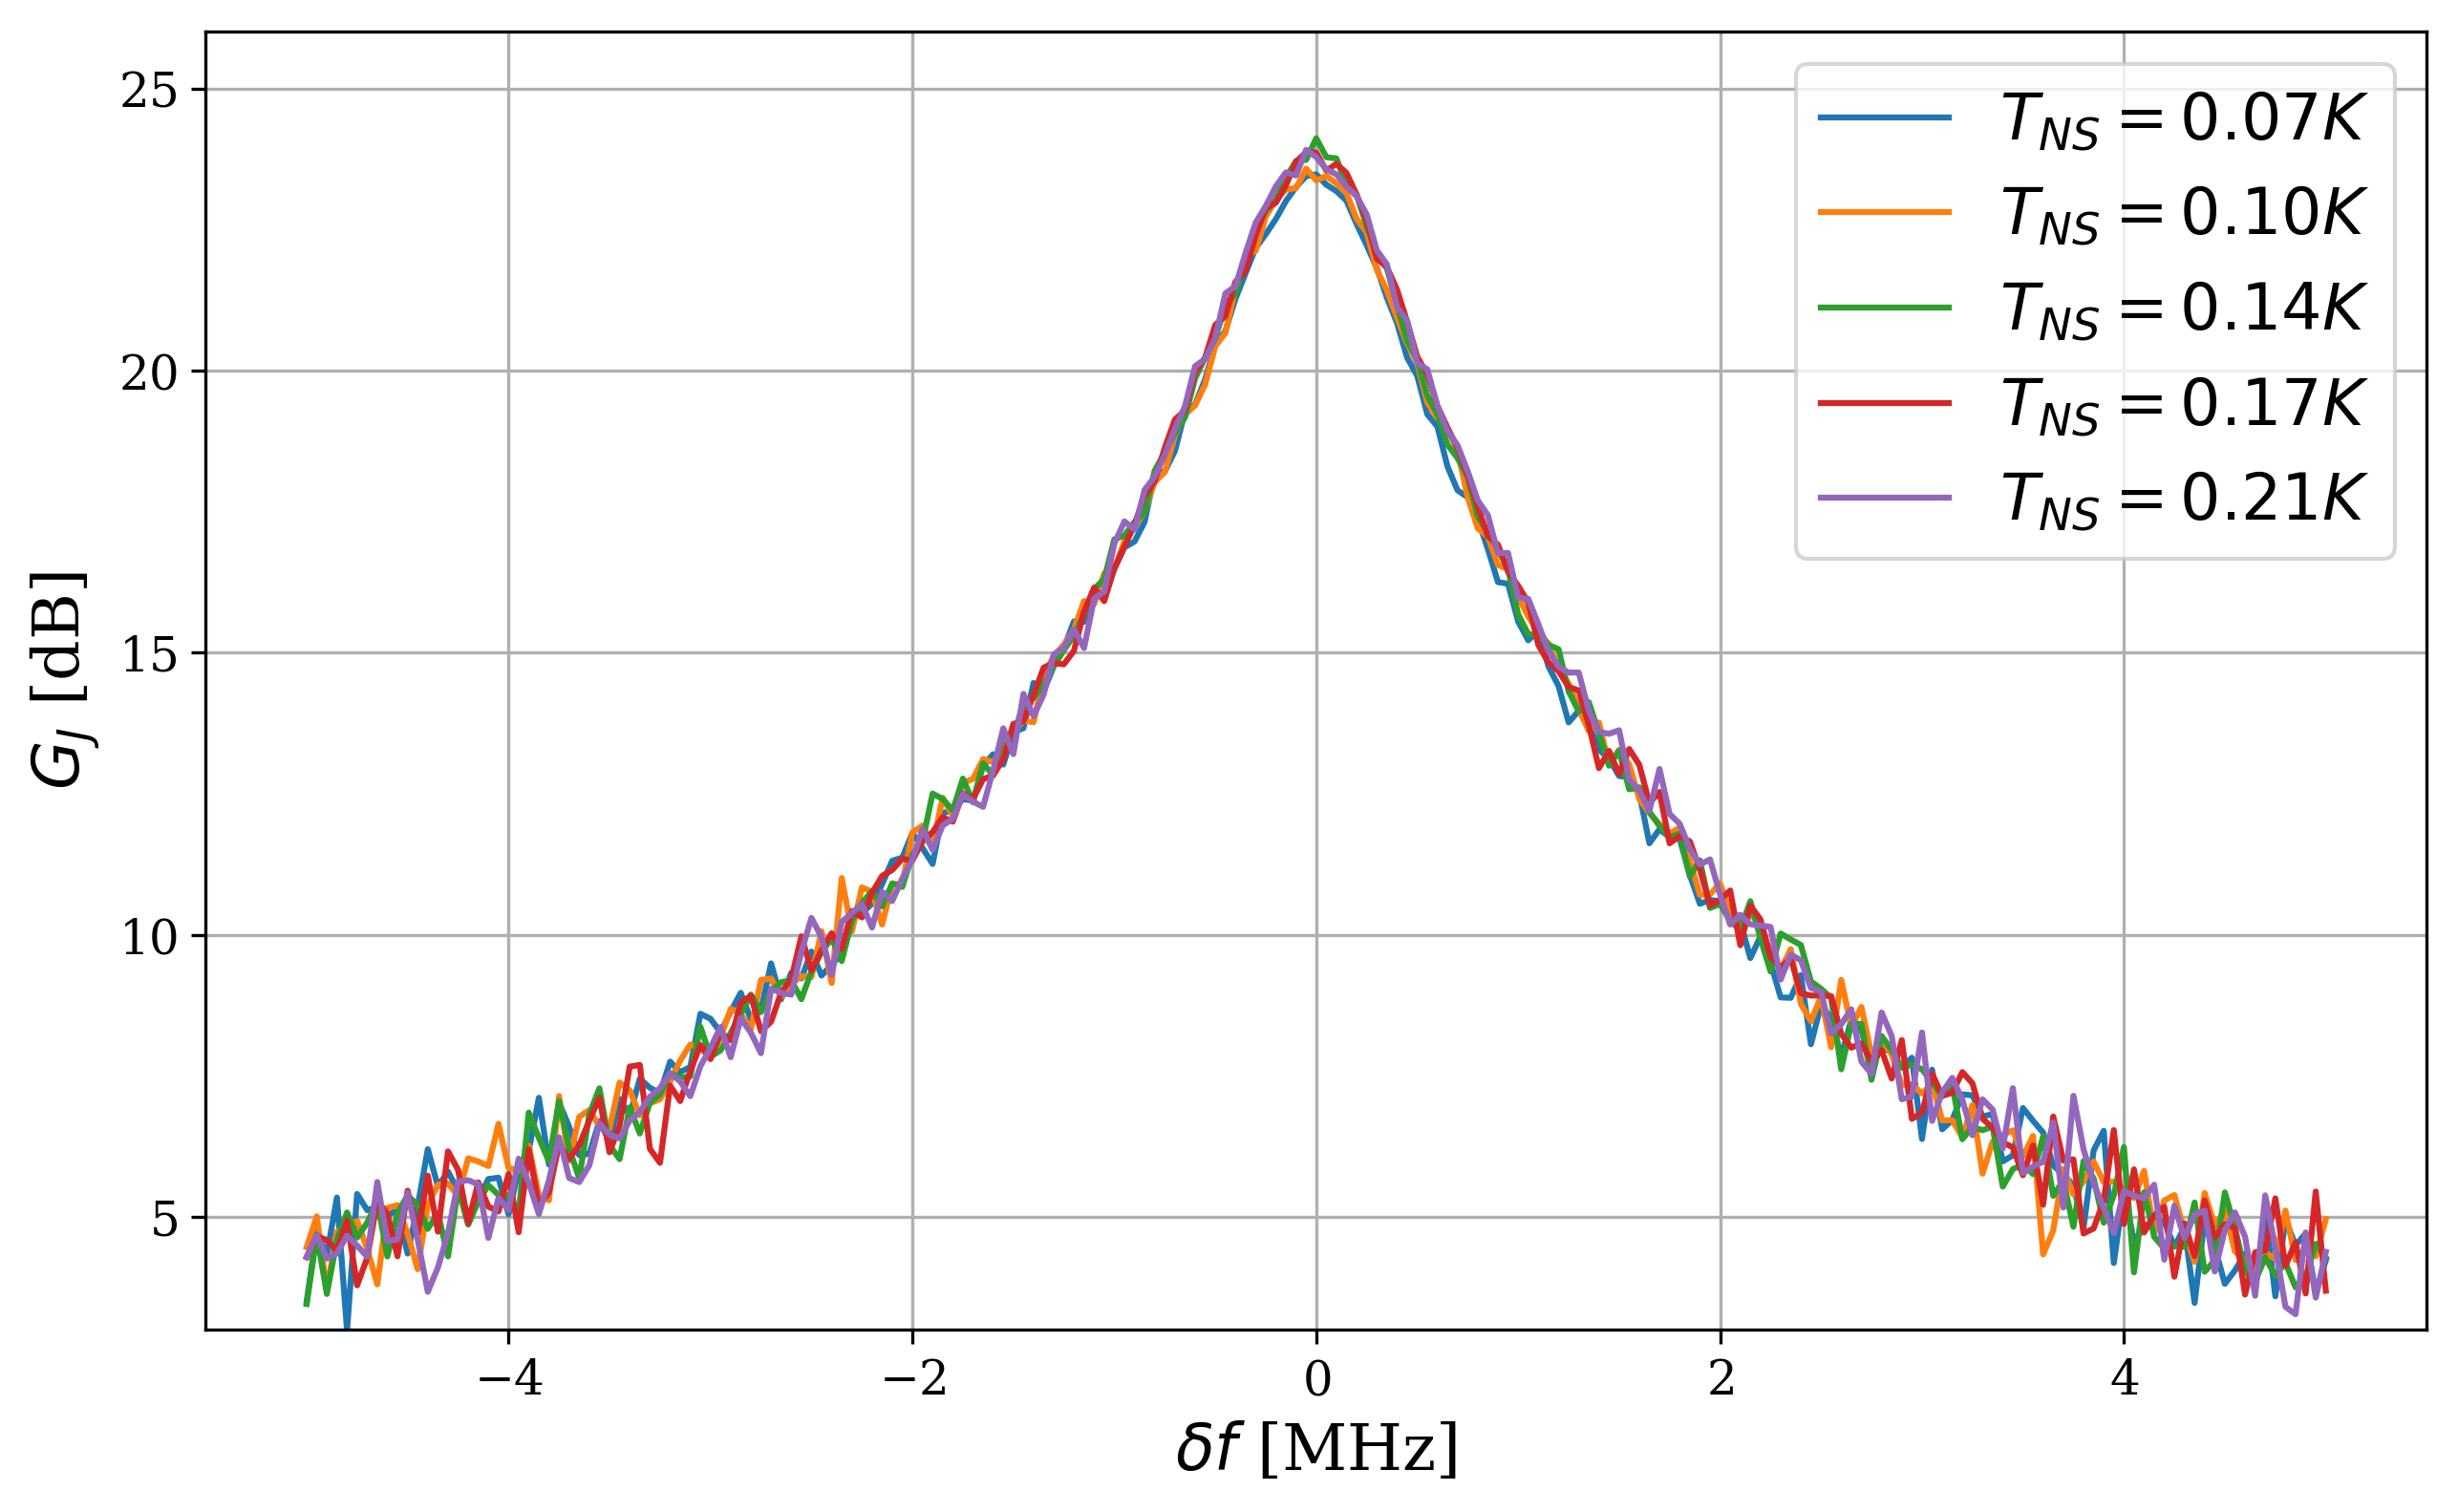

In [55]:
fig, ax = plt.subplots()
for t, gs in zip(ntds.temps, ntds.gains):
    qs = quantities(gs)
    calmags = remove_baseline(
        gs.frequencies, gs.mags,
        ntds.baseline.frequencies, ntds.baseline.mags,
        scale='log')
    df = gs.frequencies - fpeak
    ax.plot(df/1e6, calmags, label=f'$T_{{NS}}={t:.2f} K$')
    ax.set_xlabel(f"$\delta f$ [MHz]")
    ax.set_ylabel(f"$G_{{J}}$ [{qs['mags'].unit}]")

ax.legend()
ax.grid()
ax.set_ylim((3,26))

fig.savefig("gains.pdf")

# Gain vs Source Temperature

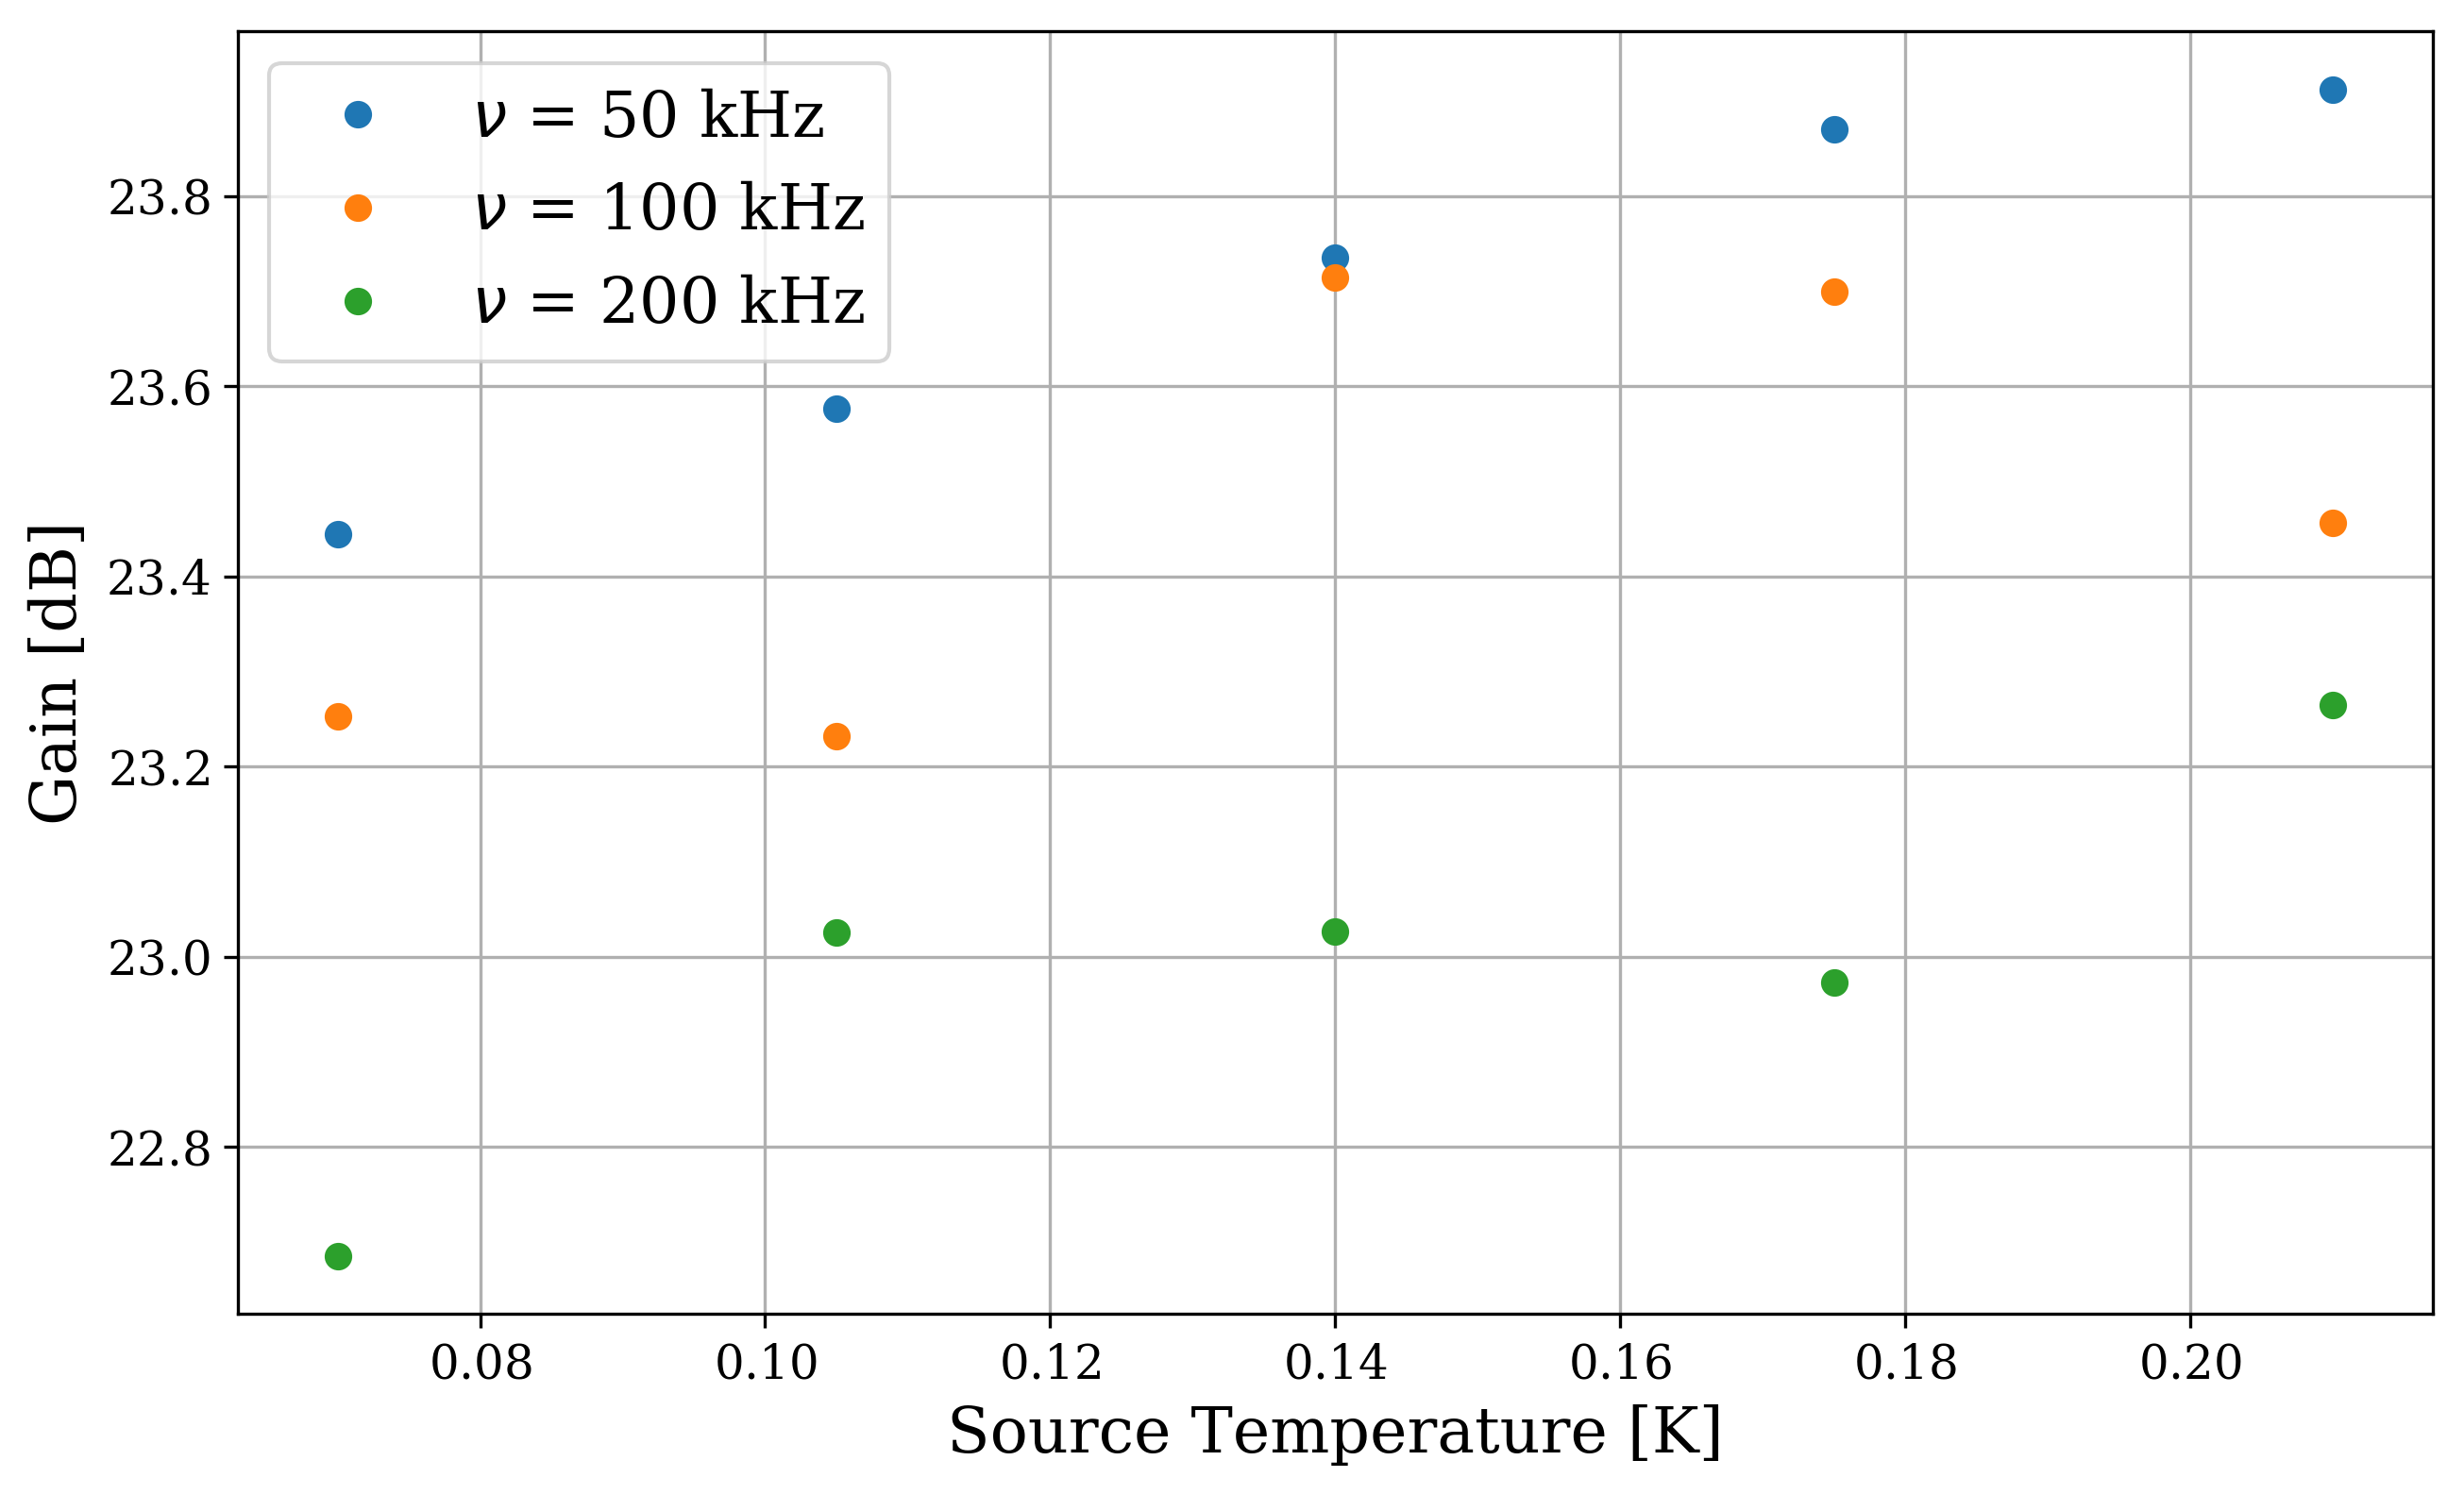

In [61]:
nulst = [50e3, 100e3, 200e3]

fig, ax = plt.subplots()
for nu in nulst:
    ntds.plot_gain_at(ntds.fpeak-nu, cal=True, ax=ax, label=f'$\\nu $ = {nu/1e3:.0f} kHz')

ax.legend()


### 2.2.3 Phase Spectra
Obtained when pump is off.  This is to make sure that the resonance did not move before and after the measurement.

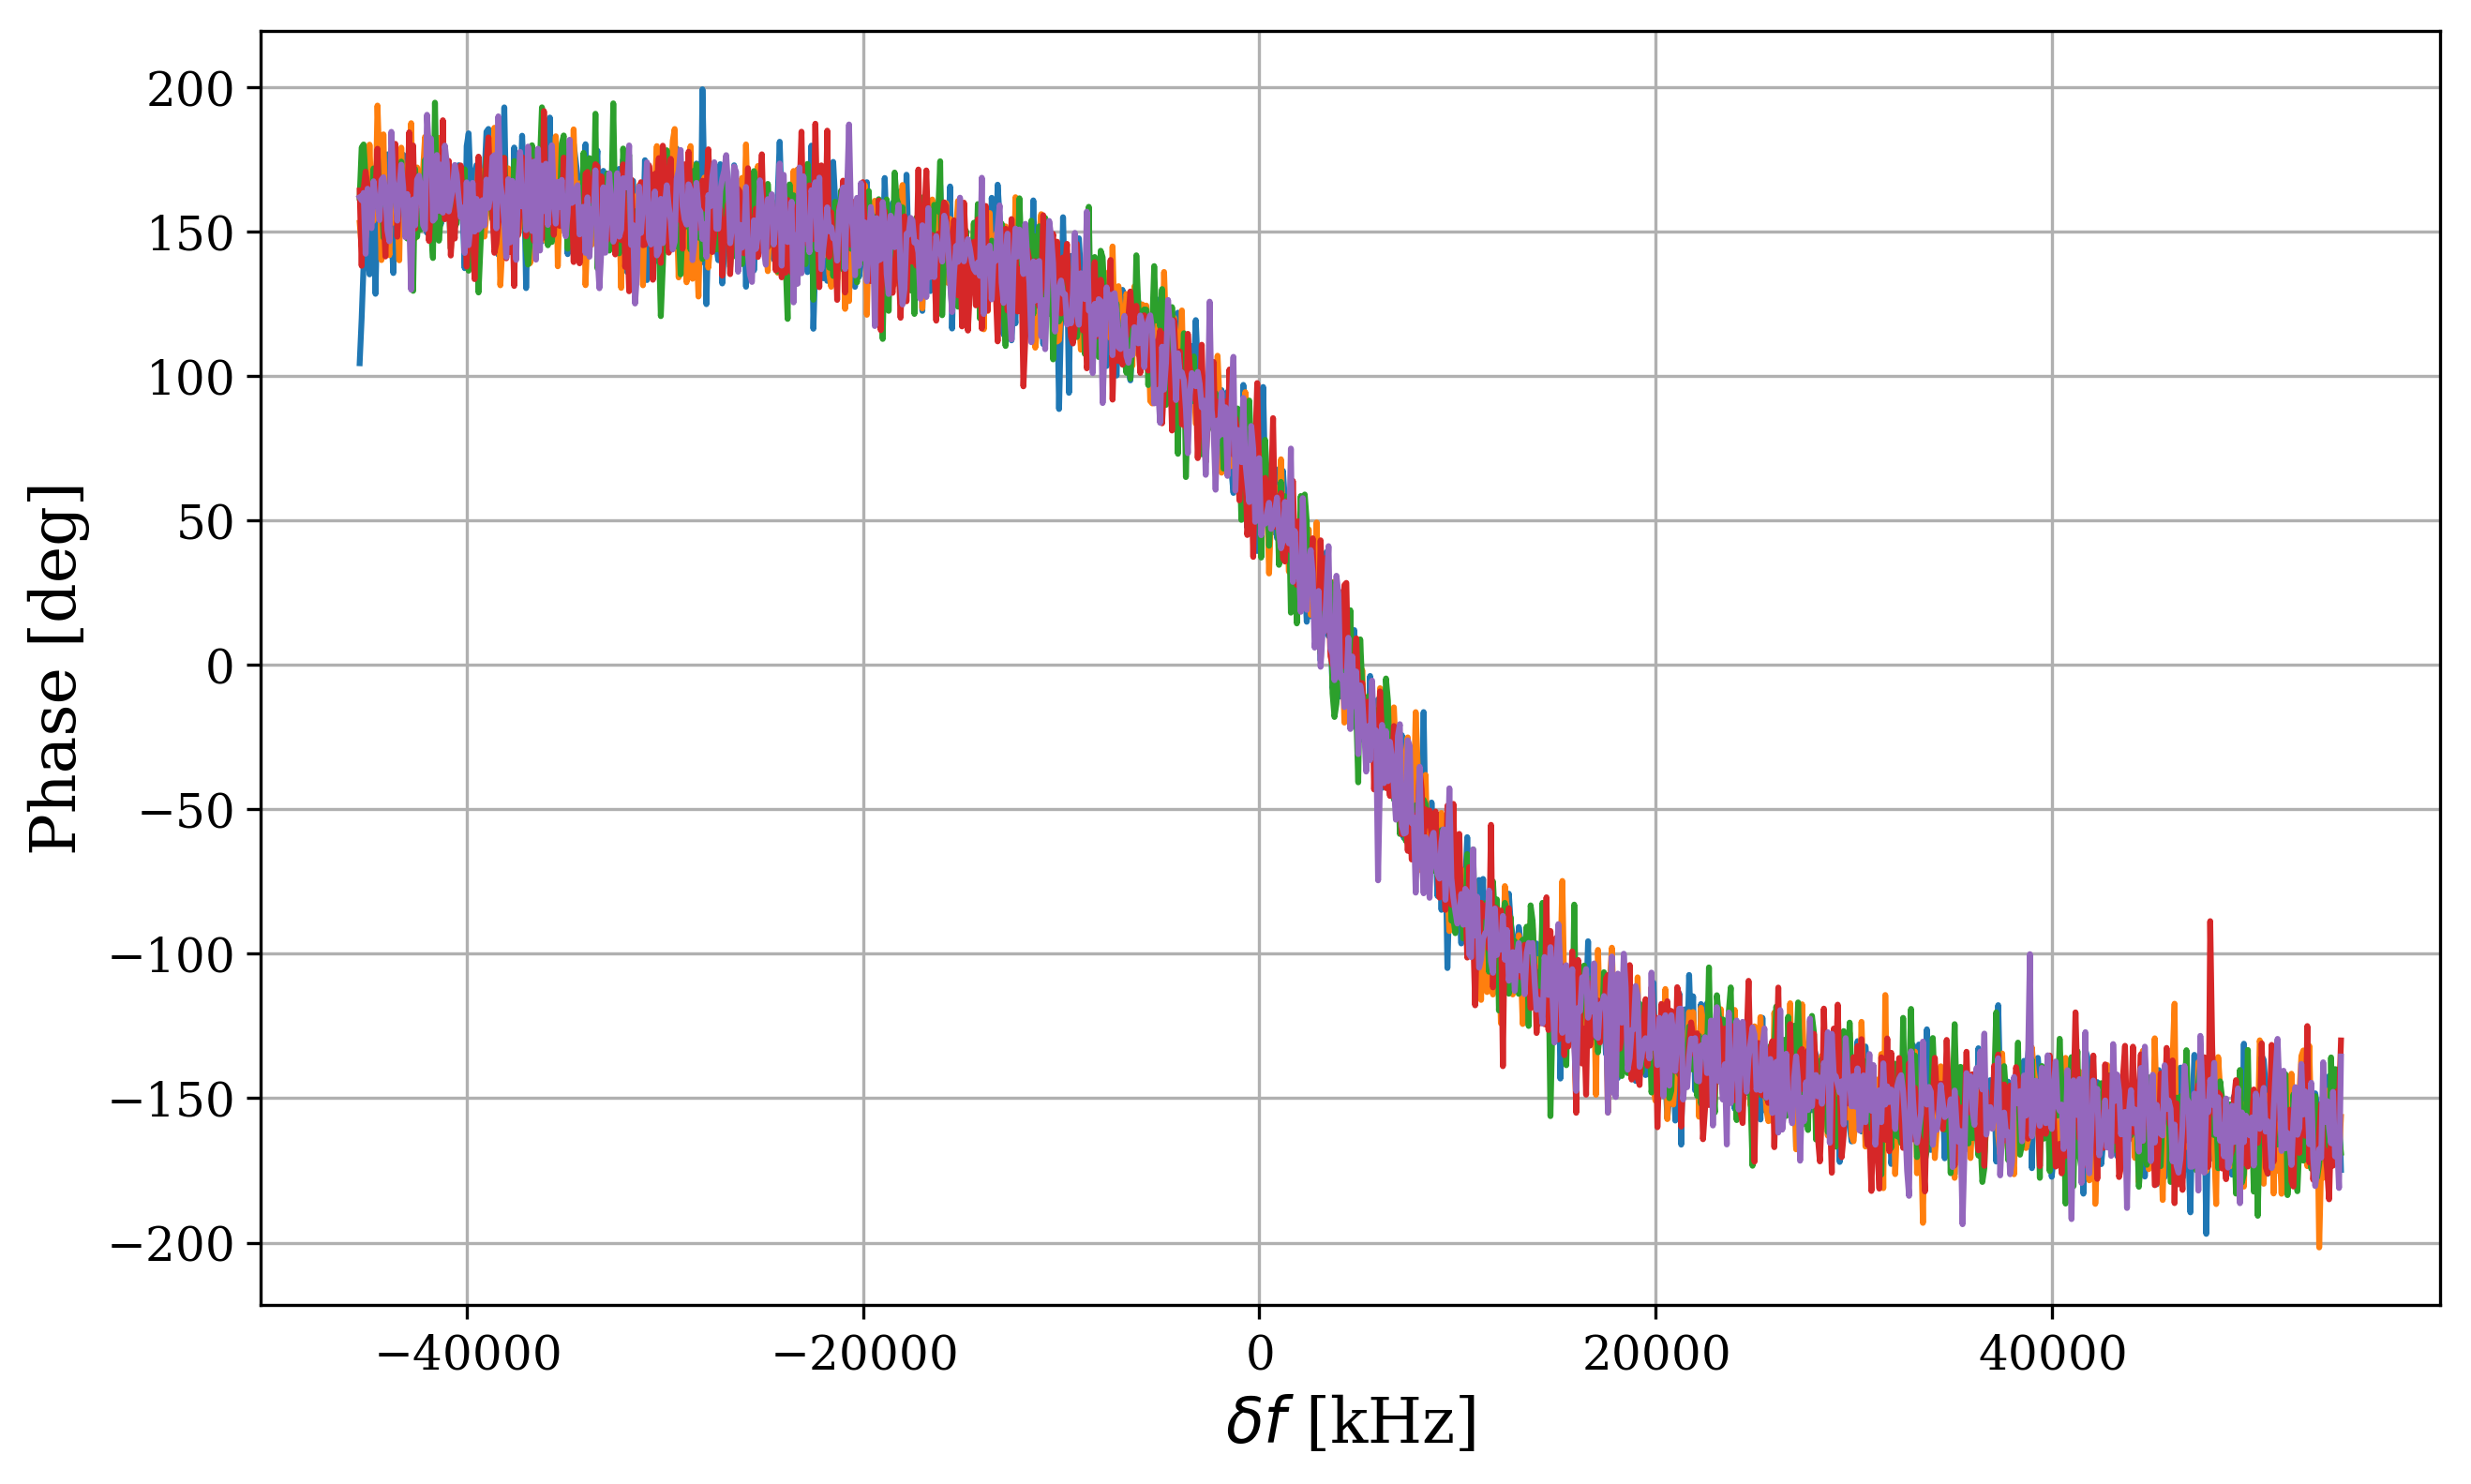

In [62]:
fig, ax = plt.subplots()
for t, frs in zip(ntds.temps, ntds.resonances):
    qs = quantities(frs)
    calphases = remove_baseline(
        frs.frequencies, frs.uphases,
        ntds.baseline.frequencies, ntds.baseline.uphases,
        scale='log')
    df = frs.frequencies - fpeak
    ax.plot(df/1e3, calphases - calphases.mean(), label=f'$T_{{NS}}={t:.2f} K$')
    ax.set_xlabel(f"$\delta f$ [kHz]")
    ax.set_ylabel(f"Phase [{qs['phases'].unit}]")

#ax.legend()
ax.grid()
                  

### 2.2.4 Noise PSD at a single bin

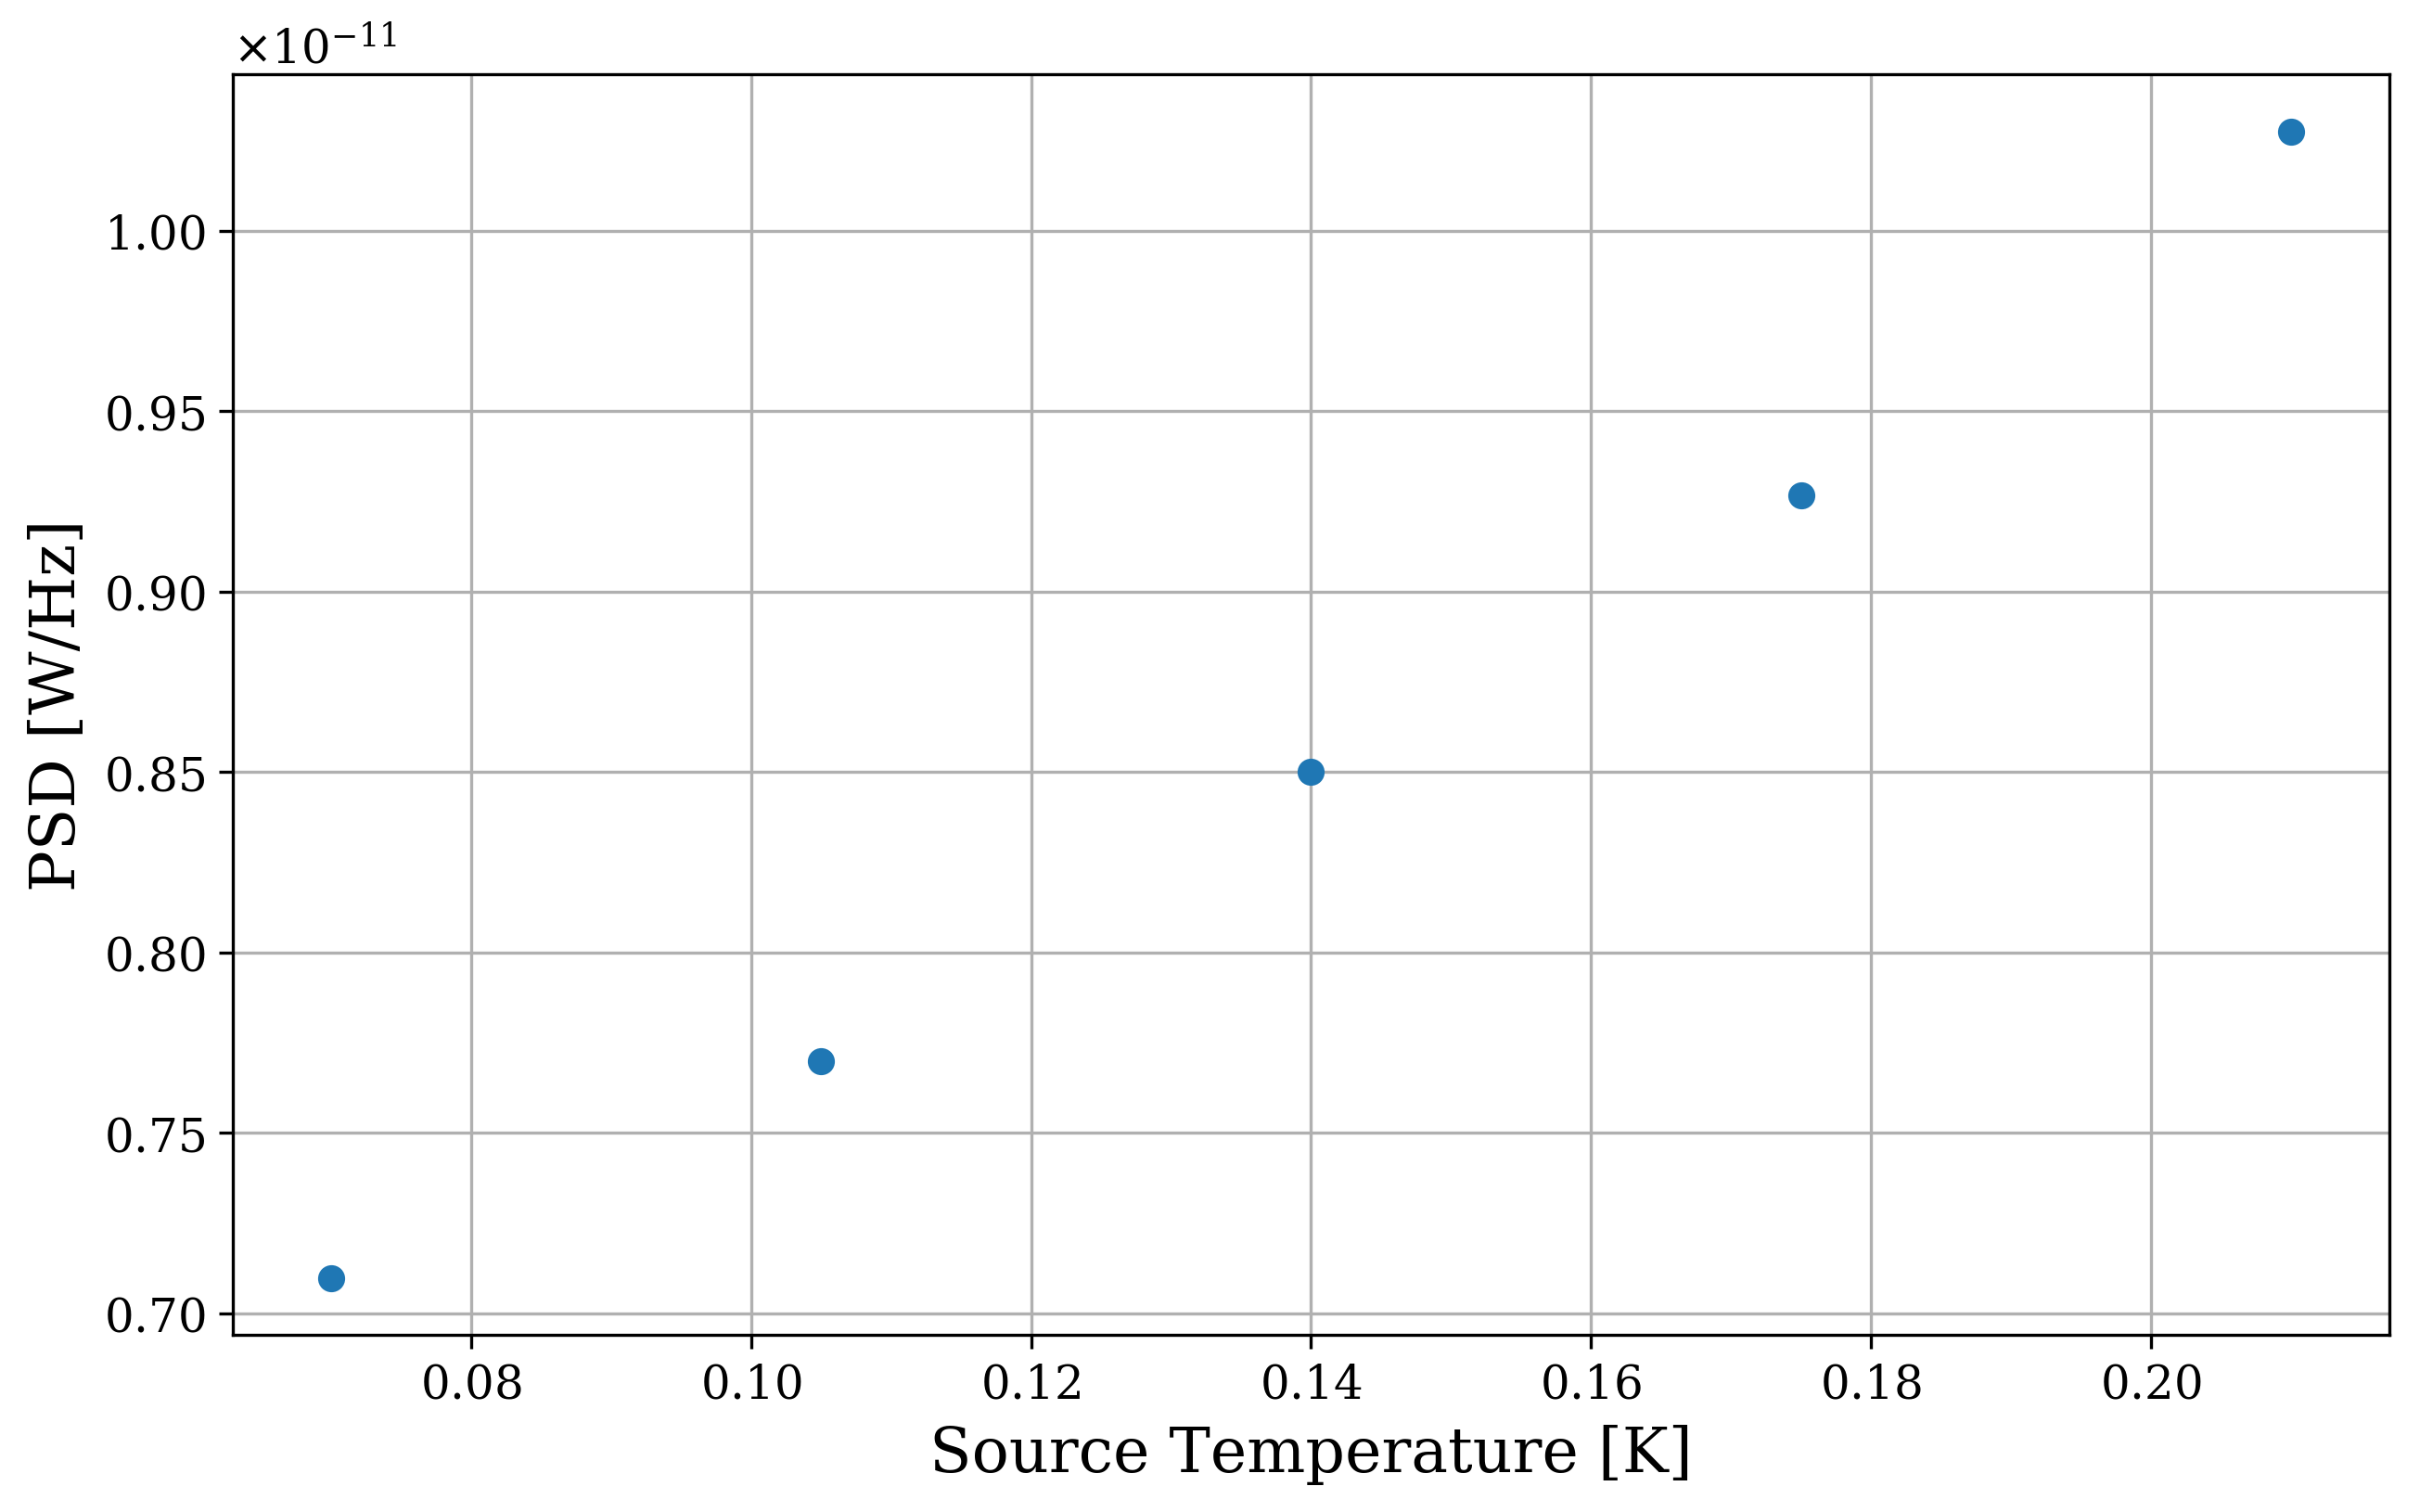

In [48]:
fcut_offset = -1e3 

fcut = ntds.fpeak + fcut_offset
fig, ax1 = plt.subplots()
ntds.plot_at(fcut, ax1)

# 3. Fitting

In [50]:
fitresult = ntds.fit_generic(TF, G_R, G_t, G_l, G_c1, G_c2, Tn_R)

In [51]:
results = fitresult.results
result = results[250]

print(result.fit_report())

[[Model]]
    Model(nt_generic)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 5
    # variables        = 2
    chi-square         = 1.0694e-28
    reduced chi-square = 3.5646e-29
    Akaike info crit   = -326.073742
    Bayesian info crit = -326.854866
[[Variables]]
    g_alpha:  1.1580e+11 +/- 5.7348e+09 (4.95%) (init = 1.398272e+08)
    tn_beta:  1.20199630 +/- 0.06884784 (5.73%) (init = 0)
    kB:       1.380649e-23 (fixed)
    p_n_f:    1.939304e-24 (fixed)
    b_c2:     0.0964782 (fixed)
    b_c1:     0.04712855 (fixed)
    tn_r:     2 (fixed)
    g_i:      8.301602 (fixed)
    g_j:      9.301602 (fixed)
    g_c2:     0.9120108 (fixed)
    g_c1:     0.9549926 (fixed)
    g_l:      0.9885531 (fixed)
    g_t:      0.9549926 (fixed)
    t_f:      0.04 (fixed)
    f:        5.843003e+09 (fixed)
    p_beta:   1.6595e-23 +/- 9.5055e-25 (5.73%) == 'kB*tn_beta'
    g:        6.1189e+10 +/- 3.0303e+09 (4.95%) == 'g_alpha*g_j/(g_j+g

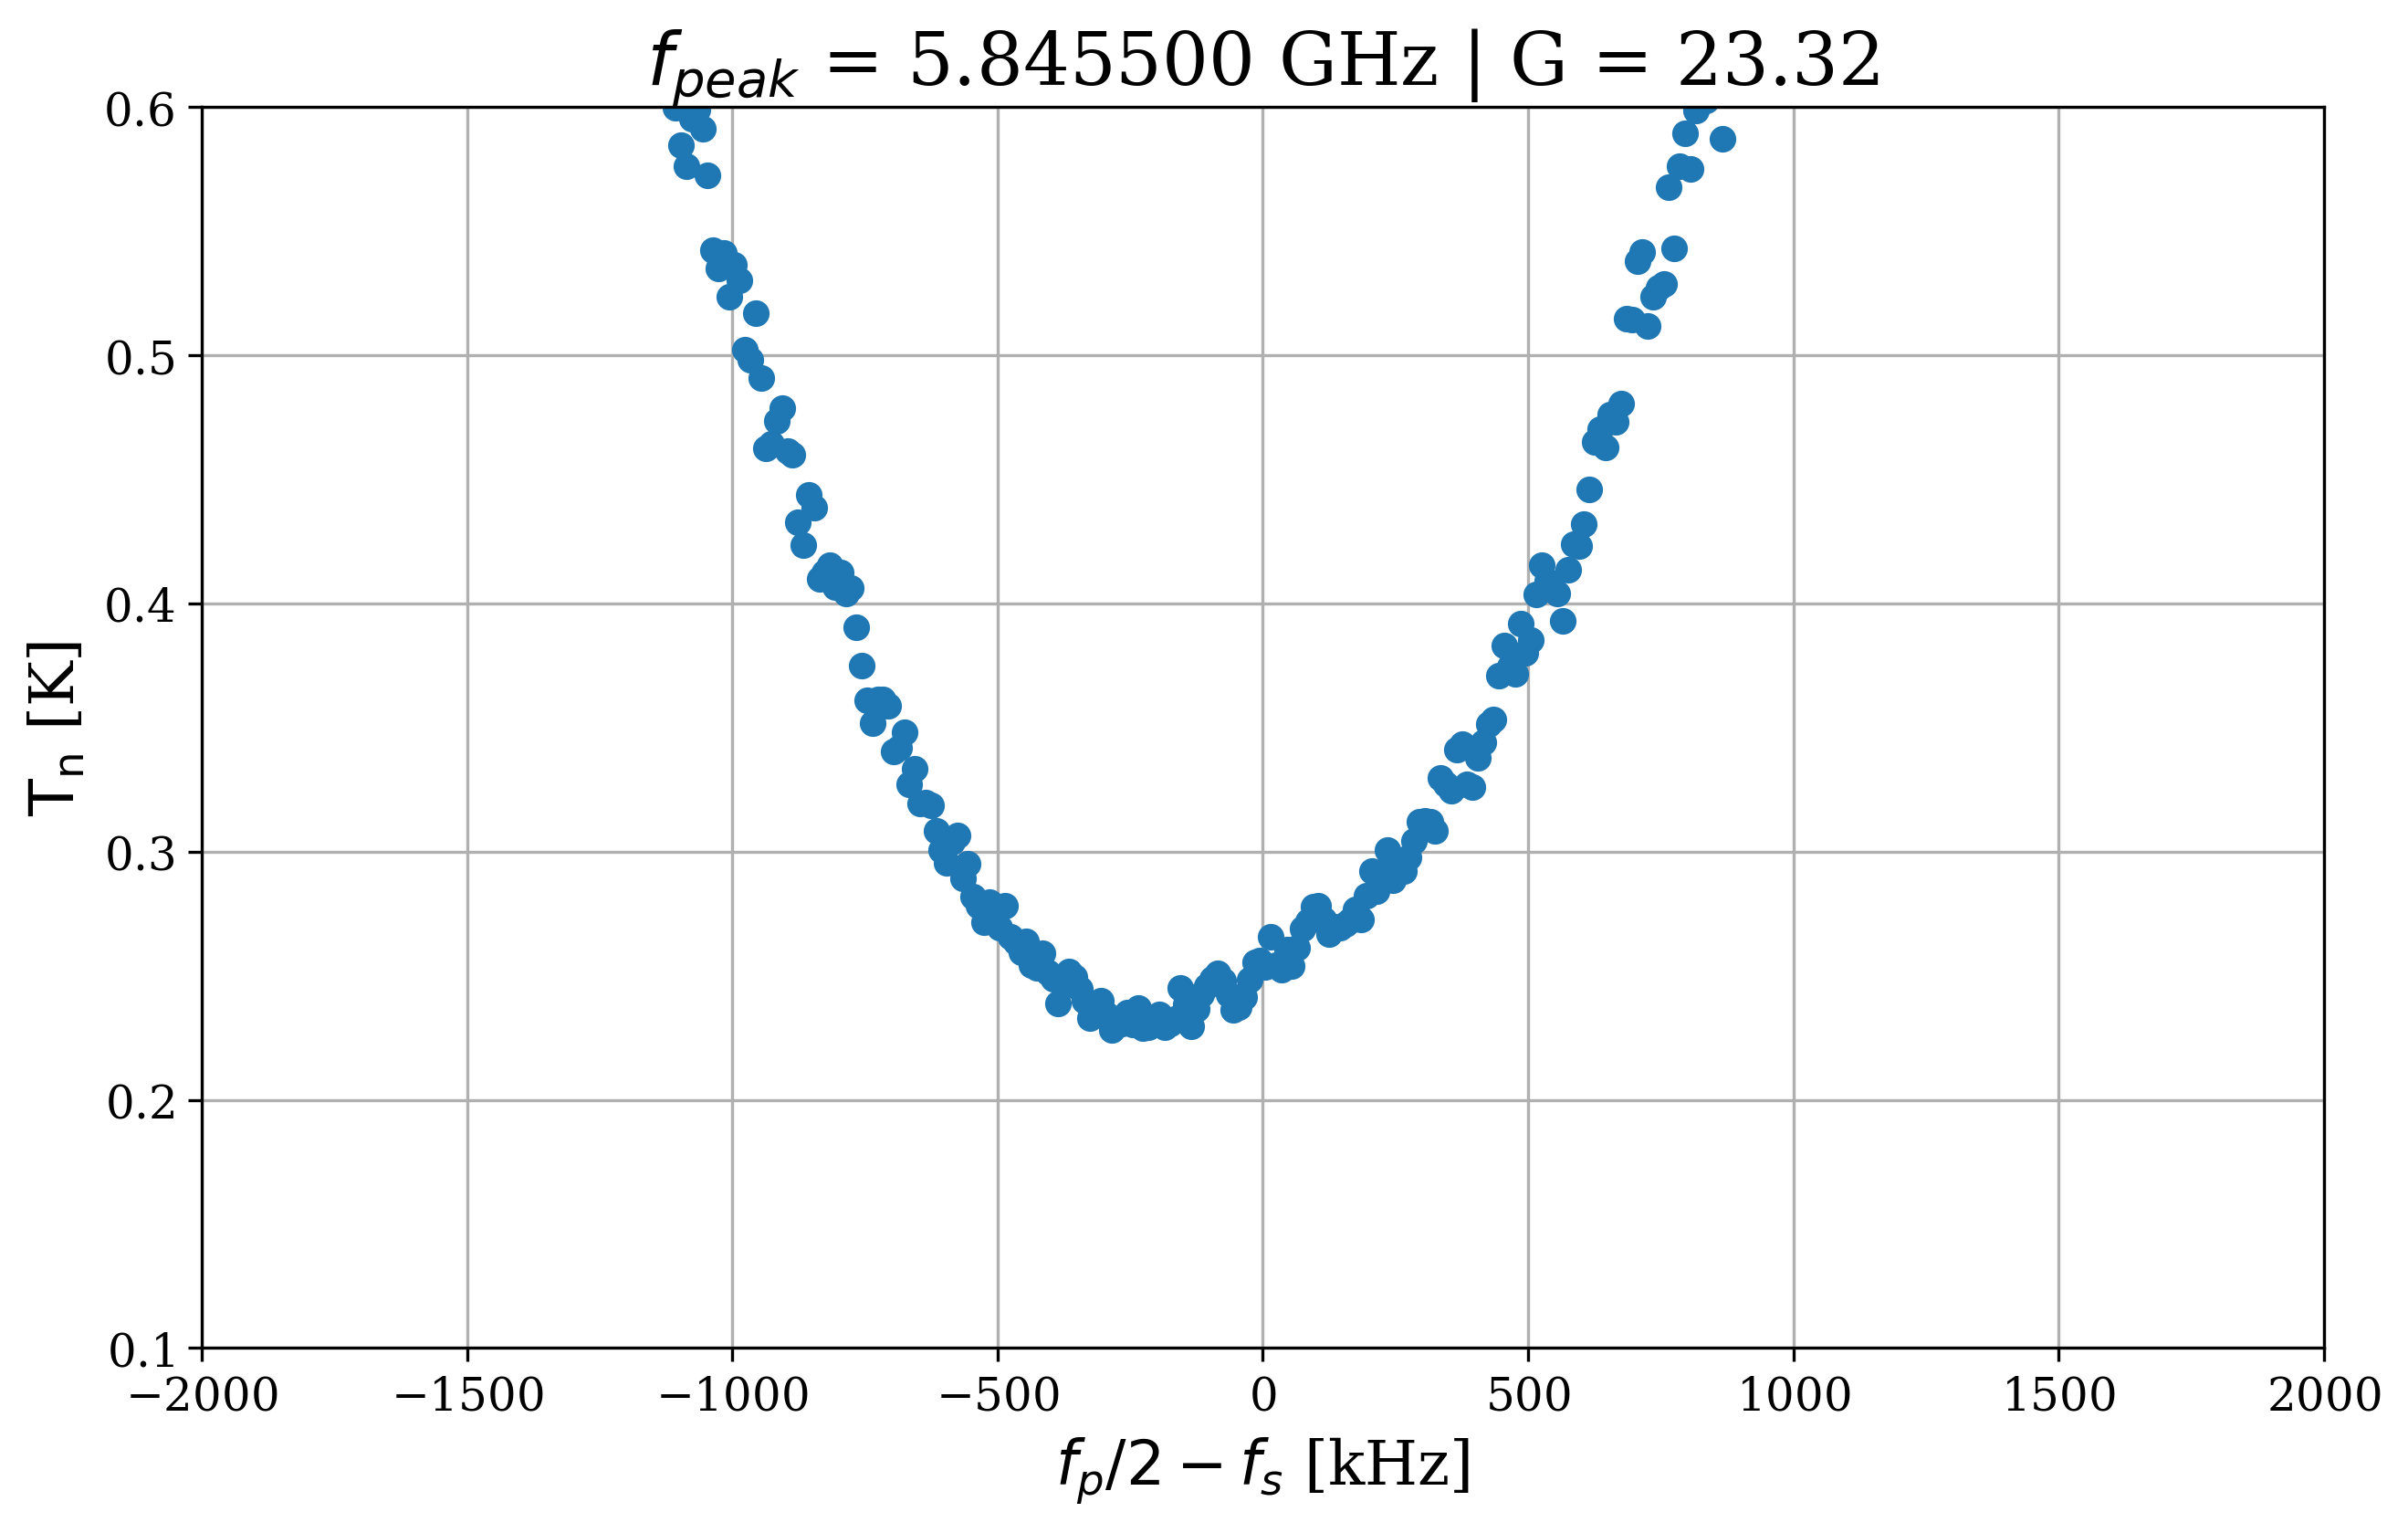

In [52]:
fig, ax = plt.subplots()
ax = fitresult.plot()
#fitresult_simple.plot(ax=ax, label="simple")
ax.set_xlim((-2000, 2000))
ax.set_ylim((0.1,0.6))
ax.set_title(f"$f_{{peak}}$ = {ntds.tup.peak_frequency/1e9:.6f} GHz | G = {ntds.tup.offset_gain:.2f}");

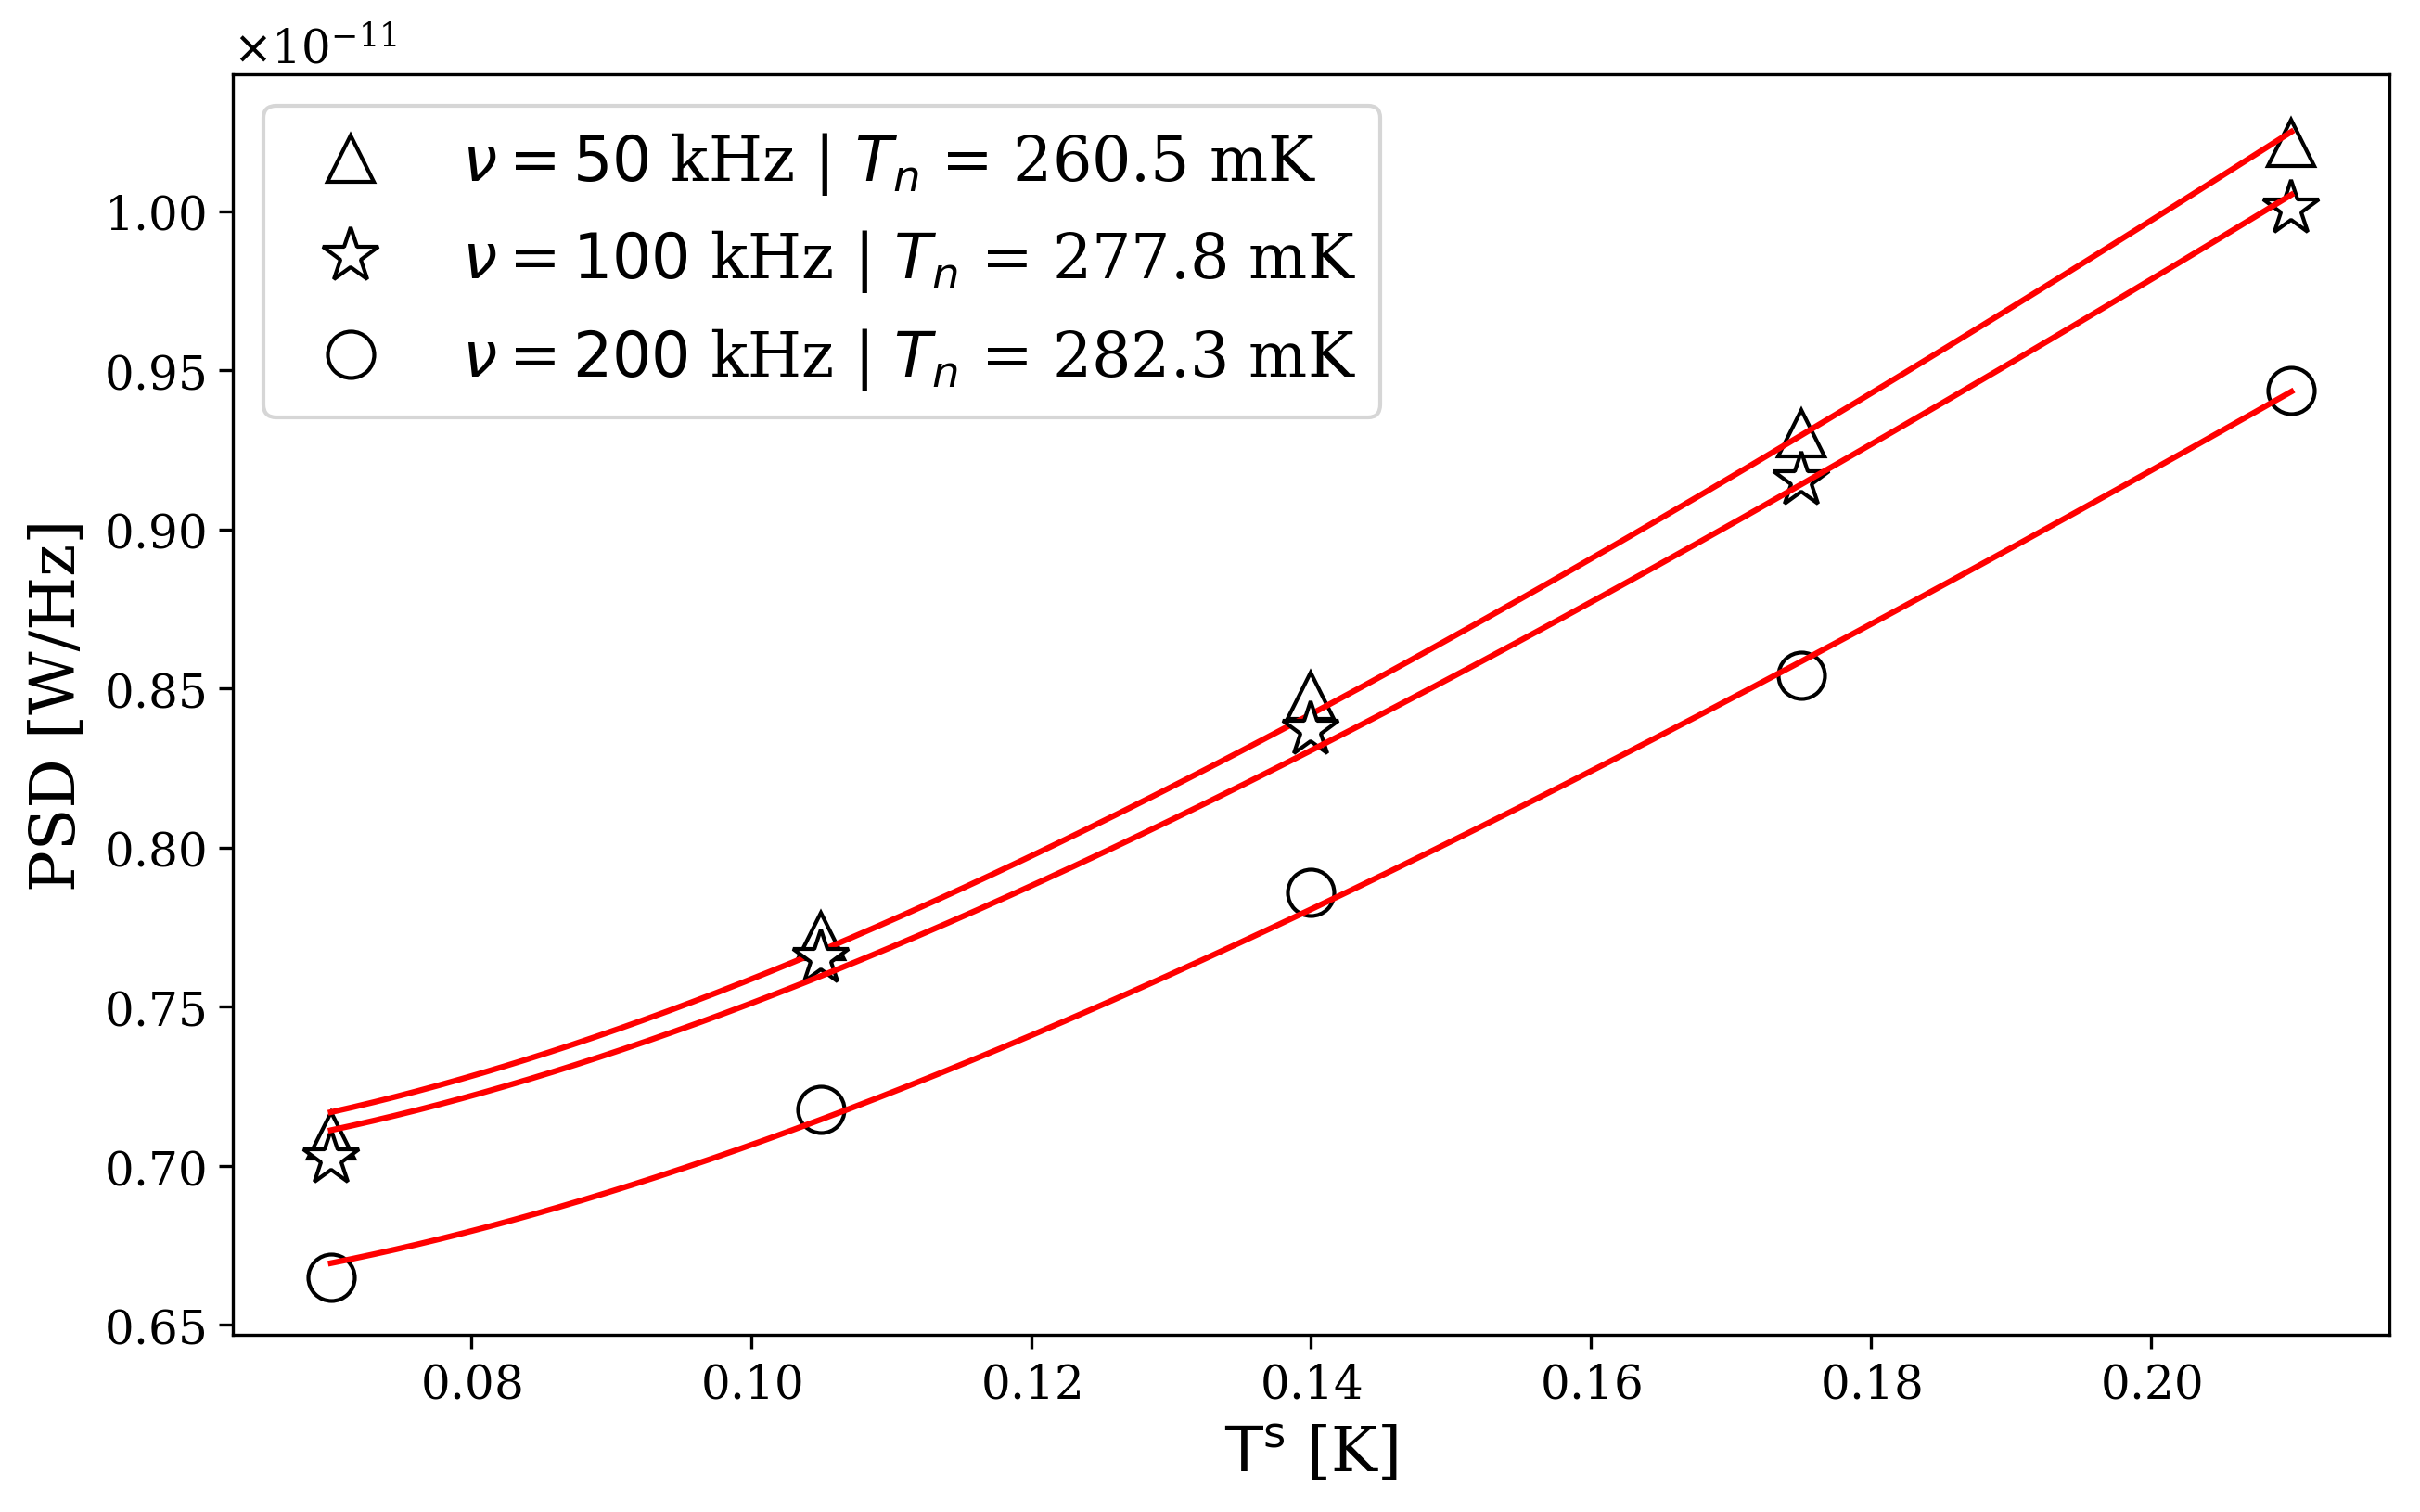

In [53]:

def plot_fits(
        fitresult,
        nu1=50e3, nu2=100e3, nu3=200e3,
        ax=None, textscale=1):
    if ax is None:
        fig, ax = plt.subplots()
    params = {'g': {'fmt': ".1f", 'apply': lin2db_pow, 'unit': 'dB', 'symbol': '$G_\mathrm{tot}$'}}

    temps = fitresult.temperatures
    ti, tf = temps[0], temps[-1]
    tevaldom = np.linspace(ti, tf, 1000)

    f1, result1 = fitresult.result_at(fitresult.fpeak - nu1)
    f2, result2 = fitresult.result_at(fitresult.fpeak - nu2)
    f3, result3 = fitresult.result_at(fitresult.fpeak - nu3)

    labelfmt = "$ \\nu = {nu:.0f} $ kHz | $ T_n $ = {t_n:.1f} mK"
    label1 = labelfmt.format(nu=nu1/1e3, t_n=result1.params['tn']*1e3)
    label2 = labelfmt.format(nu=nu2/1e3, t_n=result2.params['tn']*1e3)
    label3 = labelfmt.format(nu=nu3/1e3, t_n=result3.params['tn']*1e3)

    ax.plot(temps, result1.data, '^k', markersize=textscale*12, markerfacecolor='w', label=label1)
    ax.plot(tevaldom, result1.eval(t=tevaldom), 'r')
    ax.plot(temps, result2.data, '*k', markersize=textscale*15, markerfacecolor='w', label=label2)
    ax.plot(tevaldom, result2.eval(t=tevaldom), 'r')
    ax.plot(temps, result3.data, 'ok', markersize=textscale*12, markerfacecolor='w', label=label3)
    ax.plot(tevaldom, result3.eval(t=tevaldom), 'r')
    ax.legend()

    ax.set_xlabel("$\mathrm{{T}}^\mathrm{{s}}$ [K]")
    ax.set_ylabel("PSD [W/Hz]")
    return ax

fig, ax = plt.subplots()
plot_fits(fitresult, ax=ax)


# Fit All
This is to perform fit on all of the data we have.

fr:  The resonance frequency estimated by phase measurement.
fpeak:  The peak frequency of the gain spectrum set by the half pump frequency.

*IMPORTANT*:  For repeating measurements, the below notifications of "procuring dataset for sweep" will be wrong!  Rely on fr|fpeak information instead.

In [22]:
def fit_all(bs: SweepBrowser):
    freq_sp_ghz = bs.sweepdf.fr.unique()/1e9
    fitresults = []
    try:
        for ntds in bs.iterate_nt_datasets():
            fpeak = ntds.tup.peak_frequency/1e9
            fres = ntds.tup.resonance/1e9
            print(f"Processing tup (fr|fpeak): {fres:.6f}|{fpeak:.6f} GHz")
            fitresult = ntds.fit_generic(TF, G_R, G_t, G_l, G_c1, G_c2, Tn_R)
            fitresults.append(fitresult)
    except IndexError:
        print("Some dataset were incomplete, processed until then.")
    return fitresults

In [23]:
bs = SweepBrowser.from_path(DIR, temperature_col=1, frequency_col=0)
fitresults = fit_all(bs)

[15:47:42|INFO] Procuring dataset for sweep f: 2.280000 GHz


Processing tup (fr|fpeak): 5.850098|5.845500 GHz


[15:48:54|INFO] Procuring dataset for sweep f: 2.280000 GHz


Processing tup (fr|fpeak): 5.850098|5.845500 GHz


In [64]:
fig, ax = plt.subplots()

for i, fitresult in enumerate(fitresults):
    fpeak = fitresult.fpeak/1e9
    ax = fitresult.plot(label=f"i={i:d}")

ax.set_xlim((-3000, 3000))
ax.set_ylim((0.08,2))

ax.legend()

#ntspect = NTSpectrum(fitresult.frequencies, tn, tnerr, g, gerr)
#ntspect.to_csv("")

fig.savefig('ntrep.pdf')

# Plot Paperesque
Include a few systematic error bar.

In [63]:
FBAND = 2000

IT = 0
fr = fitresults[IT]

fig, ax = plt.subplots()

fr.plot(ax=ax, fmt='ok')

insax = plt.axes([.33, .6, .35, .3])
plot_fits(fr, ax=insax, textscale=0.5)
leg = insax.legend()
leg.remove()
insax.legend(fontsize=MIDFONTSIZE*0.5)

ax.set_xlabel('$\\nu$ [kHz]')
ax.set_xlim(-FBAND/2, FBAND/2)
ax.set_ylim((0, 0.6))

